In [110]:
# Packages used
using Distributions
using LinearAlgebra
using Plots
using PrettyTables
using Random
using Statistics
using GLM
using DataFrames
using StatsModels
using ShiftedArrays

In [111]:
# Parameters
ρ = .95;            # persistence AR(1) 
σ = .007;           # variance of error term
μ = 0;              # in the slides, AR(1) process was z_t = (1-ρ)*μ + ρ*z_{t-1} + error; here, the process is different, but note that the mean of the process is μ
m = 3;              # scaling parameter
N = 9;              # number of grid points

In [112]:
# Function to discretize the process of shocks via Tauchen

function Tauchen(rho, sigma, mu, scale, number_pts)
    upper_bound = scale * sigma / sqrt(1 - rho^2)
    lower_bound = -upper_bound
    grid_z = LinRange(lower_bound, upper_bound, number_pts)

    delta_z = (upper_bound - lower_bound) / (number_pts - 1)

    P = zeros(number_pts, number_pts)

    dist = Normal(mu, sigma)

    for i = 1:number_pts
        P[i,1] = cdf(dist, (grid_z[1] - (1 - rho) * mu .- rho * grid_z[i] + delta_z / 2))
        P[i, end] = 1 - cdf(dist, (grid_z[end] - (1 - rho) * mu - rho * grid_z[i] - delta_z / 2))

        for j = 2:(number_pts-1)
            P[i,j] = cdf(dist, (grid_z[j] + delta_z / 2 - (1 - rho) * mu - rho * grid_z[i])) -
                        cdf(dist, (grid_z[j] - delta_z / 2 - (1 - rho) * mu - rho * grid_z[i]))
        end
    end
    
    return P, grid_z
end

Tauchen (generic function with 1 method)

In [113]:
# Function to discretize the process of shocks via Rouwenhorst 

function Rouwenhorst(rho, sigma, number_pts)
    sigma_z = sqrt(sigma^2*((1-rho^2)^-1));
    upper_bound = sigma_z*sqrt(number_pts-1);
    lower_bound = -upper_bound;
    grid_z_rou = LinRange(lower_bound, upper_bound,number_pts); 

    p = (1+rho)/2; # variable used to compute P recursively

    P_rou = [p 1-p; 1-p p]; # matrix 2 by 2
    
    # Compute P recursively
    for i = 3:number_pts
        P_rou = p*[P_rou zeros(i-1,1); zeros(1,i-1) 0] + (1-p)*[zeros(i-1,1) P_rou; zeros(1,i-1) 0] + (1-p)*[zeros(1,i-1) 0; P_rou zeros(i-1,1)] + p*[zeros(1,i-1) 0; zeros(i-1,1) P_rou];  
    end

    # Normalizing the rows so they add to 1
    for j = 1:number_pts
        P_rou[j,:] = P_rou[j,:]/sum(P_rou[j,:])
    end

    return P_rou, grid_z_rou
end

Rouwenhorst (generic function with 1 method)

In [114]:
### ITEM 1 ###

# Transition Matrix
T, z_grid = Tauchen(ρ, σ, μ, m, N);

# Setting a table 
pretty_table(round.(T;digits=4); header = ["$k" for k = 1:N],
            title = "Transition Matrix via Tauchen's Method",
            row_labels = ["$x" for x = 1:N],
            border_crayon = crayon"bold yellow",
            tf = tf_simple)

Transition Matrix via Tauchen's Method
==== ======== ======== ======== ======== ======== ======== ======== ======== =========
           1        2        3        4        5        6        7        8        9  
==== ======== ======== ======== ======== ======== ======== ======== ======== =========
  1   0.7644   0.2347   0.0009      0.0      0.0      0.0      0.0      0.0      0.0  
  2   0.0592   0.7405   0.1997   0.0006      0.0      0.0      0.0      0.0      0.0  
  3   0.0001   0.0747   0.7569   0.1679   0.0004      0.0      0.0      0.0      0.0  
  4      0.0   0.0001   0.0931   0.7669   0.1396   0.0002      0.0      0.0      0.0  
  5      0.0      0.0   0.0002   0.1147   0.7702   0.1147   0.0002      0.0      0.0  
  6      0.0      0.0      0.0   0.0002   0.1396   0.7669   0.0931   0.0001      0.0  
  7      0.0      0.0      0.0      0.0   0.0004   0.1679   0.7569   0.0747   0.0001  
  8      0.0      0.0      0.0      0.0      0.0   0.0006   0.1997   0.7405   0.0592  
  9 

In [115]:
### ITEM 2 ###

# Transition Matrix
T_rou, z_grid_rou = Rouwenhorst(ρ, σ, N);

# Setting a table 
pretty_table(round.(T_rou;digits=4); header = ["$k" for k = 1:N],
            title = "Transition Matrix via Rouwenhorst's Method",
            row_labels = ["$x" for x = 1:N],
            border_crayon = crayon"bold yellow",
            tf = tf_simple)

Transition Matrix via Rouwenhorst's Method
==== ======== ======== ======== ======== ======== ======== ======== ======== =========
           1        2        3        4        5        6        7        8        9  
==== ======== ======== ======== ======== ======== ======== ======== ======== =========
  1   0.8167   0.1675    0.015   0.0008      0.0      0.0      0.0      0.0      0.0  
  2   0.0209   0.8204   0.1469   0.0113   0.0005      0.0      0.0      0.0      0.0  
  3   0.0005    0.042   0.8231   0.1261   0.0081   0.0003      0.0      0.0      0.0  
  4      0.0   0.0016    0.063   0.8247   0.1051   0.0054   0.0001      0.0      0.0  
  5      0.0   0.0001   0.0032   0.0841   0.8253   0.0841   0.0032   0.0001      0.0  
  6      0.0      0.0   0.0001   0.0054   0.1051   0.8247    0.063   0.0016      0.0  
  7      0.0      0.0      0.0   0.0003   0.0081   0.1261   0.8231    0.042   0.0005  
  8      0.0      0.0      0.0      0.0   0.0005   0.0113   0.1469   0.8204   0.0209  


In [116]:
### ITEM 3 ###

# Set a seed
Random.seed!(1);

# Number of periods
t = 10000;

# Create a vector of shocks drawn from a normal distribution with mean μ and variance σ^2
shock = rand(Normal(μ,σ),t);

# Create a vector full of zeros, whose entries will be replaced by the AR(1) process
z_t = zeros(1,t);

for i = 2:t
    z_t[i] = ρ*z_t[i-1] + shock[i];
end

# AR(1) process
z_t


1×10000 Matrix{Float64}:
 0.0  0.00194884  -0.00231937  -0.00187679  …  -0.00205355  -0.0113905

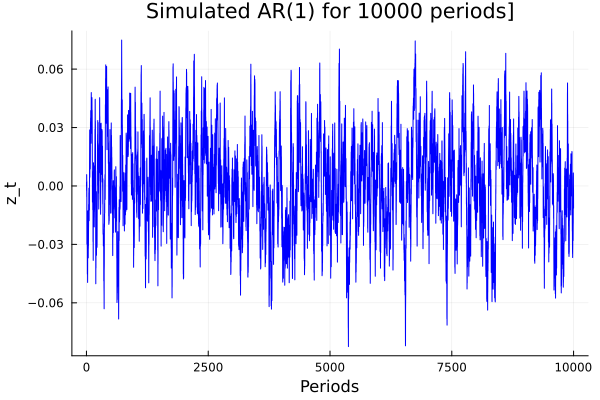

In [117]:
# Plotting graphs

# Create the plot
plot(z_t', color=:blue, label="")

# Add the title and labels with specified font sizes
title!("Simulated AR(1) for 10000 periods]", fontsize=34)
xlabel!("Periods", fontsize=28)
ylabel!("z_t", fontsize=28)


In [118]:
# Simulate the AR(1) process from Tauchen's transition matrix
med = median(z_grid)
state = findfirst(x-> x == med, z_grid)

# Vector to store the sequence of states 
z_disc = [med zeros(1,t-1)] # disc stands for discretized

for i = 2:t
    cdf_aux = T[state,1];
    for j = 1:N
        if cdf(Normal(μ,σ),shock[i]) < cdf_aux
            state = j;
            z_disc[i] = z_grid[state];
            break
        else
            cdf_aux += T[state,j+1];
        end
    end
end

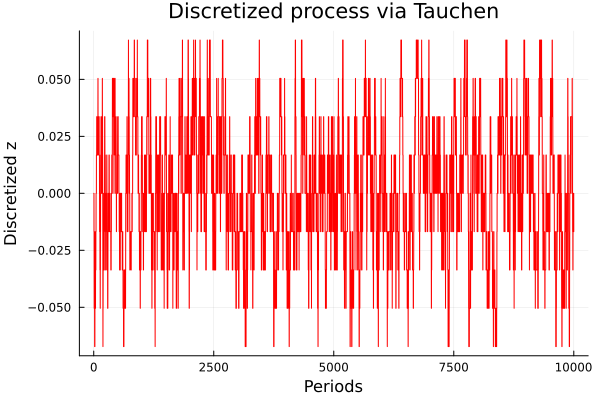

In [119]:
# Plotting graphs

# Create the plot
plot(z_disc', color=:red, label="")

# Add the title and labels with specified font sizes
title!("Discretized process via Tauchen", fontsize=34)
xlabel!("Periods", fontsize=28)
ylabel!("Discretized z", fontsize=28)

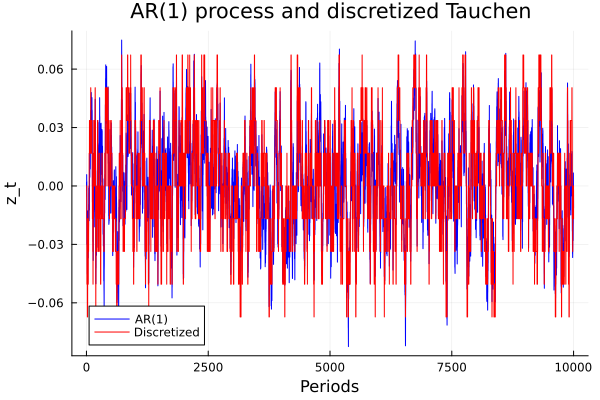

In [120]:
# Plot the graphs together
plot(1:t, [z_t', z_disc'],
xlabel = "Periods",ylabel = "z_t",title= "AR(1) process and discretized Tauchen",label = ["AR(1)" "Discretized"], color=[:blue :red])

In [121]:
# Simulate the AR(1) process from Rouwenhorst's transition matrix
med = median(z_grid_rou)
state = findfirst(x-> x == med, z_grid_rou)

# Vector to store the sequence of states 
z_disc_rou = [med zeros(1,t-1)]# disc strands for discretized

for i = 2:t
    cdf_aux = T_rou[state,1];
    for j = 1:N
        if cdf(Normal(μ,σ),shock[i]) < cdf_aux
            state = j;
            z_disc_rou[i] = z_grid_rou[state];
            break
        else
            cdf_aux += T_rou[state,j+1];
        end
    end
end

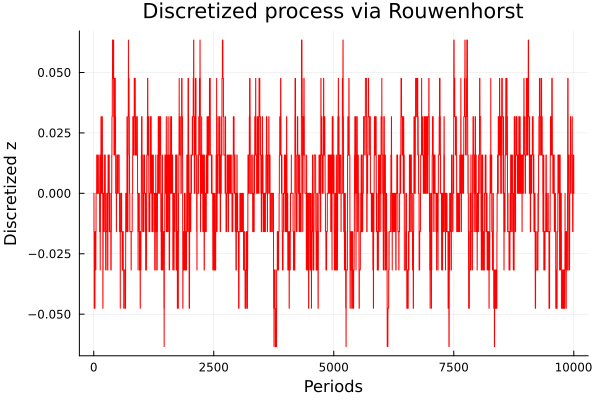

In [122]:
# Plotting graphs

# Create the plot
plot(z_disc_rou', color=:red, label="")

# Add the title and labels with specified font sizes
title!("Discretized process via Rouwenhorst", fontsize=34)
xlabel!("Periods", fontsize=28)
ylabel!("Discretized z", fontsize=28)

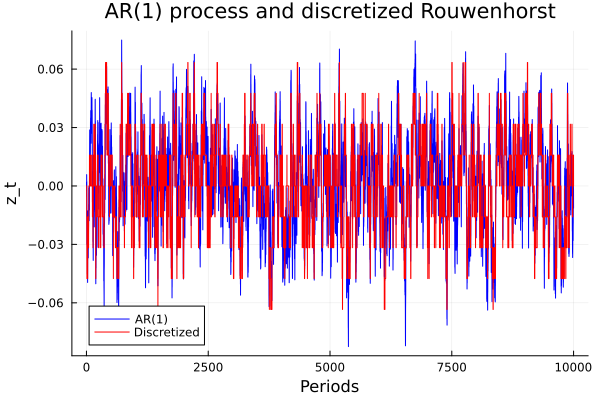

In [123]:
# Plot the graphs together
plot(1:t, [z_t', z_disc_rou'],
xlabel = "Periods",ylabel = "z_t",title= "AR(1) process and discretized Rouwenhorst",label = ["AR(1)" "Discretized"], color=[:blue :red])

In [124]:
### ITEM 4 ###

# Tauchen 
z_new = vec(z_disc) # z_disc is a 2-dimensional array (1 x 10000), so here I'm transforming it into a vector
df = DataFrame(z_new = z_new) # create a DataFrame 
df.lag1 = lag(df.z_new, 1) # generate the lagged variable
df = dropmissing(df) # remove any rows that contain missing values created by the lagging process
reg_tauchen = lm(@formula(z_new ~ lag1), df) # run the regression of z_disc on its first lag
println(coeftable(reg_tauchen)) # print the table

──────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  6.4314e-5  8.18237e-5    0.79    0.4319  -9.60769e-5  0.000224705
lag1         0.95644    0.00292046  327.50    <1e-99   0.950715    0.962165
──────────────────────────────────────────────────────────────────────────────


In [125]:
# Rouwenhorst 
z_new = vec(z_disc_rou) # z_disc is a 2-dimensional array (1 x 10000), so here I'm transforming it into a vector
df = DataFrame(z_new = z_new) # create a DataFrame 
df.lag1 = lag(df.z_new, 1) # generate the lagged variable
df = dropmissing(df) # remove any rows that contain missing values created by the lagging process
reg_rou = lm(@formula(z_new ~ lag1), df) # run the regression of z_disc on its first lag
println(coeftable(reg_rou)) # print the table


────────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  3.45902e-5  7.03734e-5    0.49    0.6231  -0.000103356  0.000172536
lag1         0.954354    0.00298722  319.48    <1e-99   0.948499     0.96021
────────────────────────────────────────────────────────────────────────────────


In [126]:
#= 
Note that the coefficients associated with the lag are close to 0.95 in both regressions, 
which indicate that the estimated processes based on the simulated data are close to the data 
generating process.
=#

In [128]:
# Calculate and print the 95% confidence intervals for the coefficients
ci_tauchen = confint(reg_tauchen, level = 0.95)
ci_rou = confint(reg_rou, level = 0.95)

# Get the confidence interval only for the coefficient of the lagged variable
cilag_tauchen = ci_tauchen[2,:] 
cilag_rou = ci_rou[2,:]

# Print the confidence intervals
println("95% Confidence Interval (Tauchen): ", cilag_tauchen)
println("95% Confidence Interval (Rouwenhorst): ", cilag_rou)

95% Confidence Interval (Tauchen): [0.9507151974020378, 0.9621645822669533]
95% Confidence Interval (Rouwenhorst): [0.948498590152616, 0.9602097019109894]


In [ ]:
#=
The confidence interval for the process simulated via Tauchen does not include 0.95, but the one via Rouwenhorst does. 
A possible explanation for this is that, as ρ -> 1, the Tauchen method loses efficacy.
However, note that 0.95 is not far from the confidence interval in the first case. If we increase the number of grid points (e.g., to 15 points), 
then 0.95 will probably be included in the interval for the Tauchen method. 
=#